# Case Study - Data scraping and analysis
---

During this week, I've scraped data from the website https://www.huffandpuffers.com/ for 42 disposable vaping products, including their name, brand, price, volume per stick, nicotine content per stick, amount of puffs per stick, user ratings, review content, and ratings for each of the three dimensions of flavor, sweetness, and long-lasting. I then performed data analysis focusing on several aspects: popularity of individual product features, product feature importance using the random forest algorithm, unsupervised classification of review text data, extraction of keywords, generation of word clouds and sentiment analysis for the products' aspect terms, and trend analysis of volume of interaction of products over time.<p>
This analysis provides insights into the disposable vaping product market, including what features are most popular, which aspect terms are most important to users and are to be improved, and how sentiment towards different products and features varies. Additionally, the trend analysis sheds light on how product engagement has evolved over time, which can be useful for businesses looking to optimize their marketing strategies and predict the product future performance and future popular aspect term.<p>
Conducted by Xindong Xu

---
### Some Context and Assumption

The Food and Drug Administration (FDA) has the authority to regulate the advertising, labeling, and promotion of e-cigarettes and other tobacco products under the Family Smoking Prevention and Tobacco Control Act of 2009. Some of the restrictions on e-cigarette advertising and promotion include:<br>

* Prohibition on TV and radio advertising;
* Restrictions on print and outdoor advertising: E-cigarette advertising in magazines, newspapers, billboards, and other outdoor locations is restricted to adults-only venues;
* Prohibition on advertising to minors;
* Health warning requirements: E-cigarette advertising and promotion must include health warnings about the potential risks associated with e-cigarette use;
* Prohibition on making false or misleading claims: E-cigarette manufacturers are prohibited from making false or misleading claims about the health benefits or risks associated with e-cigarette use;<p>
    
Due to regulatory restrictions, e-cigarette companies may not be allowed to publicly disclose their sales data or engage in certain types of advertising and promotion that would allow consumers to easily compare sales volumes between different brands. Additionally, some online retailers may not disclose sales data for competitive reasons.<p>
Thus, with my current level of data scraping programming, I have not been able to find sales of relevant disposable vape products on either https://www.huffandpuffers.com/ or any of the other common e-cigarette online retail sites.<p>
Because of the lack of sale volume data, we are going to consider studying the relationship between the products' features and the number of comments that they recieved (Volume of interactions), and their best-selling order given by the website.<br>

---

In [1]:
import re
import os
import time
import requests
import pickle
import pandas as pd
import numpy  as np

from selenium import webdriver
from selenium.webdriver import ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import ElementNotInteractableException
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

---
### Load dataset

Data to be analysed is saved in the folder './data_ok', in df_info.csv, we can find some general information for all the 42 products, and in df_review_number.csv, I stored respectively all the reviews given by the customers over a three-year time period for each product.

In [2]:
# Dataframe of general info for all products
df_info = pd.read_csv('./data_ok/df_info.csv')
df_info.rename(columns = {'Product_id': 'Best_Selling'}, inplace = True)
# When doing the data scraping, the 42 product data have been already sorted by their respective sales volume from most to least

df_info['Review_count'] = df_info['Review_count'].astype('int64')
df_info = df_info.drop(columns = ['Link'])
df_info.head()

,Best_Selling,Brand,Name,Capacity(mL),Nicotine(%),Puffs,Review_count,Score,Recommend(%),Flavor,Sweet,Lasting,Price
0,1,Flum,Flum Float Disposable Vape 5% Nicotine,8.0,5.0,3000,1033,4.8,95%,92.0385,76.6734,82.9615,14.99
1,2,Hyppe,Hyppe Max Flow Supreme Disposable Vape 5% Nico...,6.0,5.0,2000,850,4.8,96%,92.4332,72.4777,80.3412,11.99
2,3,Elf,Elf Bar BC5000 Disposable Vape 5% Nicotine,13.0,5.0,5000,937,4.9,97%,94.3750,84.9609,91.2891,14.99
3,4,Flum,Flum Pebble Disposable Vape 5% Nicotine,14.0,5.0,6000,459,4.8,96%,91.5570,79.6053,90.7346,15.99
4,5,Lucid,Lucid Air Disposable Vape 5% Nicotine,16.0,5.0,5000,334,4.7,93%,87.9310,73.2759,81.6810,14.99


In [3]:
# An example of review data, here the product is Flum Float Disposable Vape 5% Nicotine, ranking no.1 on the sales volume list
df_review_1 = pd.read_csv('./data_ok/df_review_1.csv', index_col = 'Review_id')
df_review_1.head()

,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting
Review_id,,,,,,,,
1,5.0,11 hours,Less than 2 months,Awesome,I think you guys are awesome,5.0,5.0,5.0
2,5.0,12 hours,Less than 2 months,Lasts Long time,Great flavor and lasts a very long time,5.0,5.0,5.0
3,5.0,18 hours,Less than 2 months,I like these vapes,Last a while too,3.0,3.0,3.0
4,5.0,20 hours,Less than 2 months,Love this one.,Flavor was great and lasted a while.,5.0,5.0,5.0
5,5.0,3 days,Less than 2 months,Flum Pina Polo,This is great! Has the pineapple taste and no ...,5.0,5.0,5.0


In [4]:
# Import all the 42 review data csv files into one dataframe df_review, containing all the reviews on the website
file_list = os.listdir('./data_ok/')
df_review = pd.DataFrame(columns = ['Best_Selling', 'Ratings', 'Dates', 'Date_Category', 'Heads', 'Texts', 'Flavor', 'Sweet', 'Lasting'])

for product_id, file_name in enumerate(os.listdir('./data_ok/')):
    if re.findall(r"\d+\.+csv", file_name):
        df_csv_temp = pd.read_csv('./data_ok/' + file_name)
        df_csv_temp['Best_Selling'] = product_id
        df_review = pd.concat([df_review, df_csv_temp], ignore_index=True)

df_review.head()

,Best_Selling,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting,Review_id
0,1,5.0,11 hours,Less than 2 months,Awesome,I think you guys are awesome,5.0,5.0,5.0,1.0
1,1,5.0,12 hours,Less than 2 months,Lasts Long time,Great flavor and lasts a very long time,5.0,5.0,5.0,2.0
2,1,5.0,18 hours,Less than 2 months,I like these vapes,Last a while too,3.0,3.0,3.0,3.0
3,1,5.0,20 hours,Less than 2 months,Love this one.,Flavor was great and lasted a while.,5.0,5.0,5.0,4.0
4,1,5.0,3 days,Less than 2 months,Flum Pina Polo,This is great! Has the pineapple taste and no ...,5.0,5.0,5.0,5.0


---
### Popularity of single feature

In this section, we are interested in the influence of single feature on the product's popularity. 

And first of all, we would like to draw some distribution graph of some of the product information, for example the price, Nicotine content per stick, Nicotine unit price and so on.

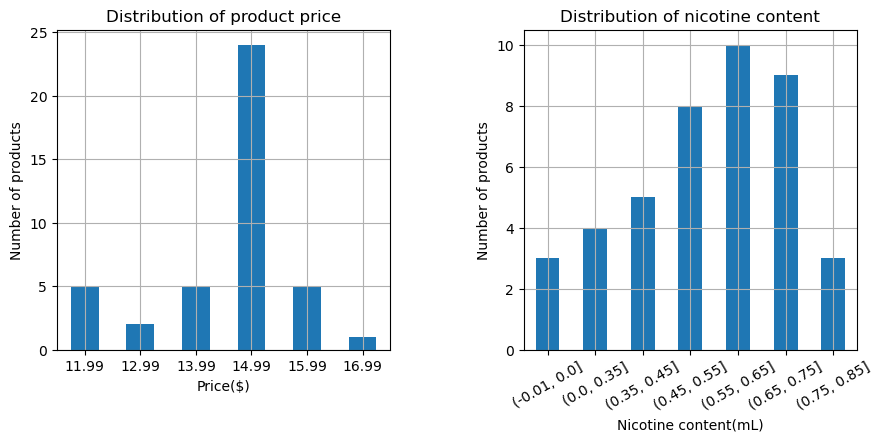

In [5]:
plt.figure(figsize = (10, 4))
plt.subplot(121)
df_info['Price'].value_counts().sort_index().plot.bar()

plt.grid()
plt.ylabel('Number of products')
plt.xlabel('Price($)')
plt.xticks(rotation = 0)
plt.title('Distribution of product price')

plt.subplot(122)
content_bins = [-0.01, 0, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]
df_info = df_info.assign(Nicotine_Content = lambda x: x['Capacity(mL)']*x['Nicotine(%)']/100)
df_info['Content_Bin'] = pd.cut(df_info['Nicotine_Content'], content_bins)
df_info['Content_Bin'].value_counts().sort_index().plot.bar()

plt.grid()
plt.ylabel('Number of products')
plt.xlabel('Nicotine content(mL)')
plt.xticks(rotation = 30)
plt.title('Distribution of nicotine content')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
plt.show()

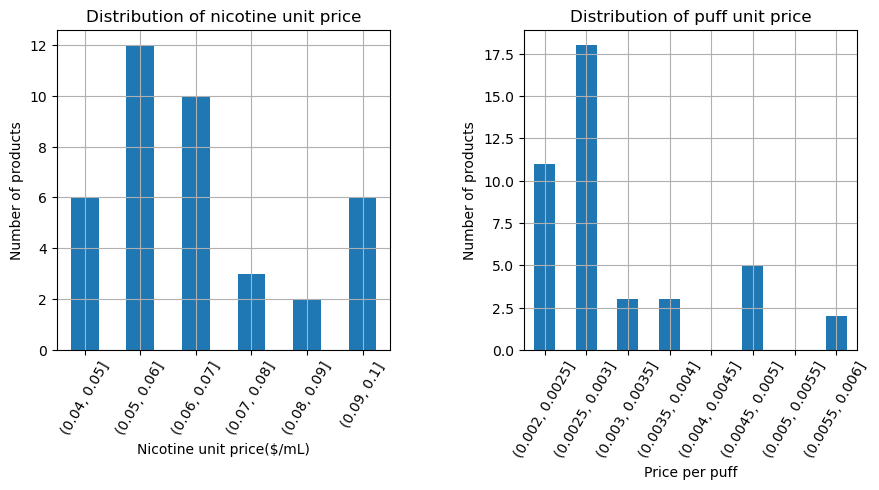

In [6]:
# Illustration of distribution of the nicotine unit price of each product
plt.figure(figsize = (10, 4))
plt.subplot(121)
unitprice_bins = np.linspace(0.04, 0.1, 7)
df_info = df_info.assign(Nicotine_Unit_Price = lambda x: x['Price']/x['Capacity(mL)']*x['Nicotine(%)']/100)
df_info['Unitprice_Bin'] = pd.cut(df_info['Nicotine_Unit_Price'], unitprice_bins)
df_info['Unitprice_Bin'].value_counts().sort_index().plot.bar()

plt.grid()
plt.ylabel('Number of products', fontsize = 10)
plt.xlabel('Nicotine unit price($/mL)', fontsize = 10)
plt.xticks(rotation = 60)
plt.title('Distribution of nicotine unit price')

# Illustration of distribution of the each puff cost of the vapes
plt.subplot(122)
unitpuff_bins = np.linspace(0.002, 0.006, 9)
df_info = df_info.assign(Puff_Unit_Price = lambda x: x['Price']/x['Puffs'])
df_info['Unitpuff_Bin'] = pd.cut(df_info['Puff_Unit_Price'], unitpuff_bins)
df_info['Unitpuff_Bin'].value_counts().sort_index().plot.bar()
plt.grid()
plt.ylabel('Number of products', fontsize = 10)
plt.xlabel('Price per puff', fontsize = 10)
plt.xticks(rotation = 60)
plt.title('Distribution of puff unit price')

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
plt.show()

Based on the distribution of this product information, <mark>we can very tentatively see that most vapes are priced at 15 dollars per stick and the nicotine content in them is concentrated at 0.45mL to 0.75mL, and that the unit price of nicotine in most of the products and price for one puff are below 0.07 dollar and 0.003 dollar respectively.<mark><p>So later, we would like to see if the price per stick, number of puffs, nicotine unit price or the price per unit will influence the popularity of the product.<p>By grouping the volume of interations by brand name and summing the review number for each brand, we can find out which brands are more popular among the custmers.

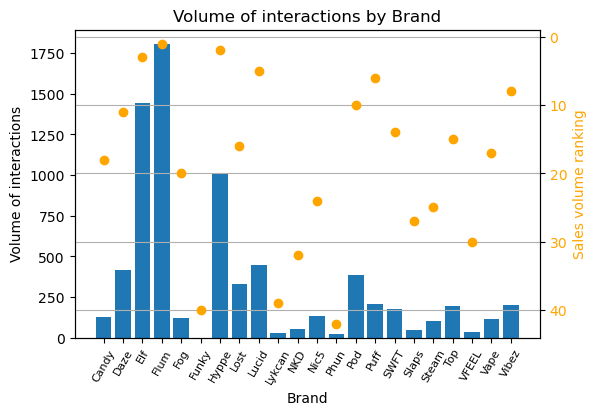

In [7]:
# Group the sales by brand name and sum the review number for each brand
inter_by_brand = df_info.groupby('Brand')['Review_count'].sum()
sales_by_brand = df_info.groupby('Brand')['Best_Selling'].min()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.bar(inter_by_brand.index, inter_by_brand.values)
ax1.set_ylabel('Volume of interactions', fontsize = 10)
ax1.tick_params(axis = 'x', labelrotation = 60, labelsize = 8)

ax2 = ax1.twinx()
plt.grid()
ax2.plot(sales_by_brand.index, -sales_by_brand.values, 'o', color = 'orange')
ax2.set_ylabel('Sales volume ranking', fontsize = 10, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ylabels = ax2.get_yticks()
ax2.yaxis.set_major_locator(mticker.FixedLocator(ylabels))
ax2.set_yticklabels([50, 40, 30, 20, 10, 0, -10])


ax1.set_xlabel('Brand', fontsize = 10)
ax1.set_title('Volume of interactions by Brand', fontsize = 12)

plt.show()

Now, by grouping the volume of interations by selling price, puff numbers and the unit price, and summing the review number for each brand, we can find out which pricing and product attributes are more popular among the custmers.

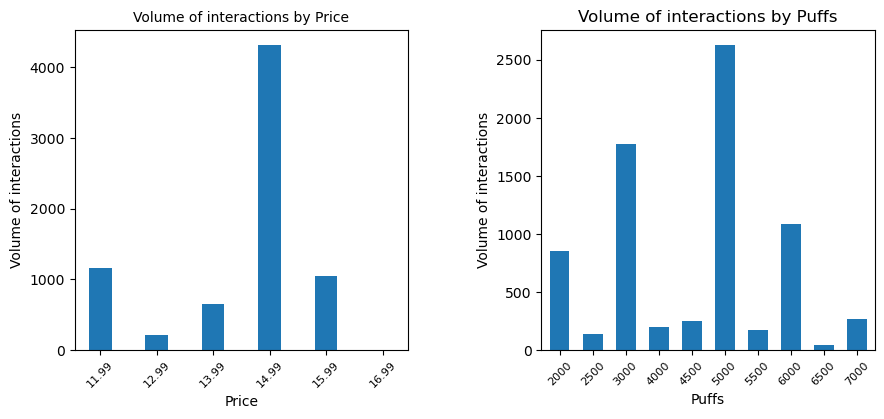

In [8]:
# group by the price bins and sum the sales
inter_by_price = df_info.groupby('Price')['Review_count'].sum()
inter_by_puffs = df_info.groupby('Puffs')['Review_count'].sum()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

inter_by_price.plot(kind = 'bar', ax = ax1, width = 0.4)
ax1.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax1.set_ylabel('Volume of interactions', fontsize = 10)
ax1.set_xlabel('Price', fontsize = 10)
ax1.set_title('Volume of interactions by Price', fontsize = 10)

inter_by_puffs.plot(kind = 'bar', ax = ax2, width = 0.6)
ax2.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax2.set_ylabel('Volume of interactions', fontsize = 10)
ax2.set_xlabel('Puffs', fontsize = 10)
ax2.set_title('Volume of interactions by Puffs', fontsize = 12)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
plt.show()

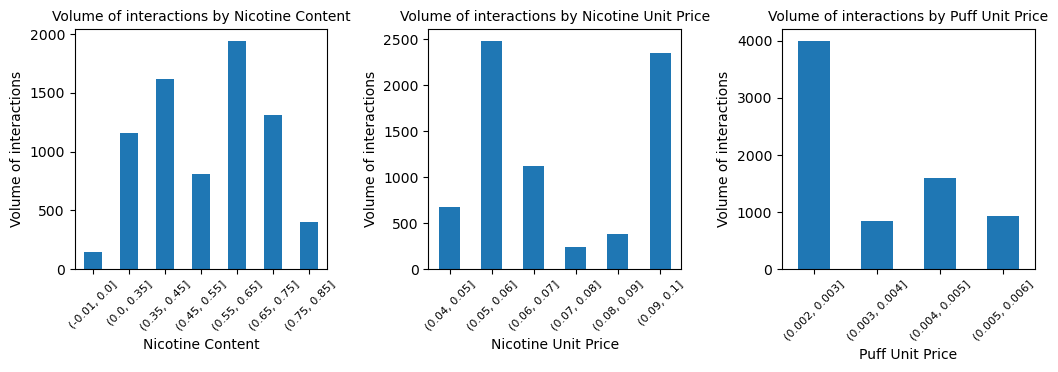

In [9]:
# Volume of interactions by Nicotine Content barchart
content_bins = [-0.01, 0, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85]
df_info['Content_Bin'] = pd.cut(df_info['Nicotine_Content'], content_bins)
inter_by_content = df_info.groupby('Content_Bin')['Review_count'].sum()
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
inter_by_content.plot(kind = 'bar', ax = ax1)
ax1.set_ylabel('Volume of interactions', fontsize = 10)
ax1.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax1.set_xlabel('Nicotine Content', fontsize = 10)
ax1.set_title('Volume of interactions by Nicotine Content', fontsize = 10)

# Volume of interactions by Nicotine Unit Price barchat
# unitprice_bins = np.linspace(0.04, 0.1, 12)
unitprice_bins = np.linspace(0.04, 0.1, 7)
df_info['Unitprice_Bin'] = pd.cut(df_info['Nicotine_Unit_Price'], unitprice_bins)
inter_by_unitprice = df_info.groupby('Unitprice_Bin')['Review_count'].sum()
# create a bar chart
inter_by_unitprice.plot(kind = 'bar', ax = ax2)
ax2.set_ylabel('Volume of interactions', fontsize = 10)
ax2.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax2.set_xlabel('Nicotine Unit Price', fontsize = 10)
ax2.set_title('Volume of interactions by Nicotine Unit Price', fontsize = 10)

# Puff Unit Price barchart
unitpuff_bins = np.linspace(0.002, 0.006, 5)
df_info['Unitpuff_Bin'] = pd.cut(df_info['Puff_Unit_Price'], unitpuff_bins)
inter_by_unitpuff = df_info.groupby('Unitpuff_Bin')['Review_count'].sum()
inter_by_unitpuff.plot(kind = 'bar', ax = ax3)
ax3.set_ylabel('Volume of interactions', fontsize = 10)
ax3.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)

ax3.set_xlabel('Puff Unit Price', fontsize = 10)
ax3.set_title('Volume of interactions by Puff Unit Price', fontsize = 10)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
plt.show()

Through observation, we found that price and the number of puffs in a single vape did not directly determine consumers' tendency to purchase, with the majority of consumers still choosing the $15 product, which is of course related to the fact that there are more products available at this price level, and the same applies to the choice of the number of puffs.<p>
It also appears that the nicotine content of a single vape and the price per nicotine unit are not directly examined by consumers. However, we found that <mark>__as the unit price of a product decreases, the product becomes more popular among buyers__, which can be explained by the tendency for consumers to prefer longer lasting products, i.e. when products are priced the same, consumers naturally prefer products that can be used for longer periods of time.

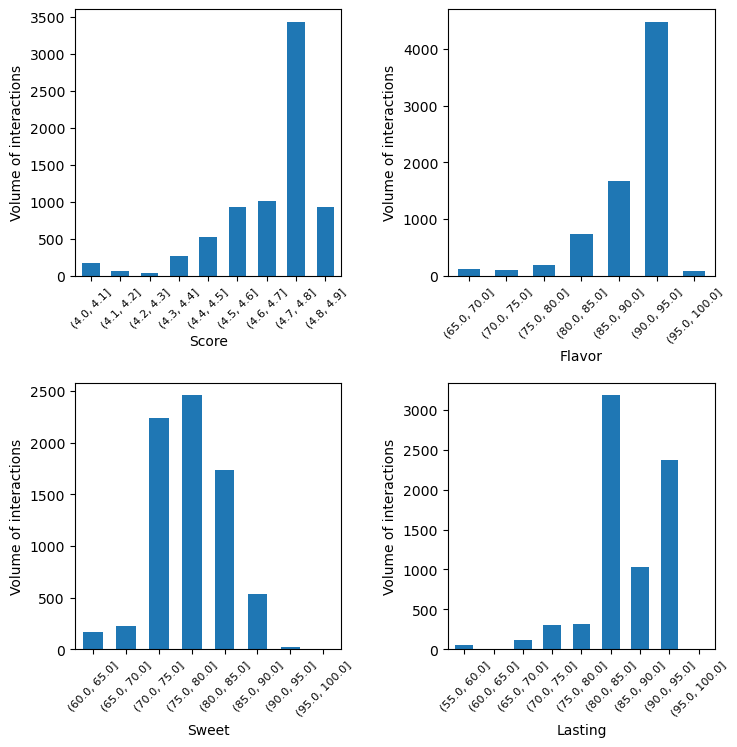

In [10]:
# group by the price bins and sum the sales
score_bins = np.linspace(4, 4.9, 10)
attr1_bins = np.linspace(65, 100, 8)
attr2_bins = np.linspace(60, 100, 9)
attr3_bins = np.linspace(55, 100, 10)

df_info['Score_Bin'] = pd.cut(df_info['Score'], score_bins)
inter_by_score = df_info.groupby('Score_Bin')['Review_count'].sum()
df_info['Flavor_Bin'] = pd.cut(df_info['Flavor'], attr1_bins)
inter_by_flavor = df_info.groupby('Flavor_Bin')['Review_count'].sum()
df_info['Sweet_Bin'] = pd.cut(df_info['Sweet'], attr2_bins)
inter_by_sweet = df_info.groupby('Sweet_Bin')['Review_count'].sum()
df_info['Lasting_Bin'] = pd.cut(df_info['Lasting'], attr3_bins)
inter_by_lasting = df_info.groupby('Lasting_Bin')['Review_count'].sum()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# plt.subplots_adjust(left = 0.1, right = 1.5)

inter_by_score.plot(kind = 'bar', ax = ax1, width = 0.6)
ax1.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax1.set_ylabel('Volume of interactions', fontsize = 10)
ax1.set_xlabel('Score', fontsize = 10)

inter_by_flavor.plot(kind = 'bar', ax = ax2, width = 0.6)
ax2.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax2.set_ylabel('Volume of interactions', fontsize = 10)
ax2.set_xlabel('Flavor', fontsize = 10)

inter_by_sweet.plot(kind = 'bar', ax = ax3, width = 0.6)
ax3.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax3.set_ylabel('Volume of interactions', fontsize = 10)
ax3.set_xlabel('Sweet', fontsize = 10)

inter_by_lasting.plot(kind = 'bar', ax = ax4, width = 0.6)
ax4.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax4.set_ylabel('Volume of interactions', fontsize = 10)
ax4.set_xlabel('Lasting', fontsize = 10)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
plt.show()

Through observation, we found that products with higher consumer ratings are more popular, and consumers’ ratings of flavors are also directly related to product sales. <mark>In the follow-up, we can ___continue to study which flavors of vape are more likely to be rated as high scores by consumers___ (for example, mint, strawberry, aloe, etc.), and we can use this to change the company's future marketing and product strategies.<p>
In addition, products with ___moderate sweetness___ are more likely to be favored by consumers, not that sweeter vapes are better. In terms of durability, it is still the case that the longer the product is available, the more sales it will have.

### Random Forest Feature importance

In this section, we are going to study the product feature importance using the random forest algorithm.

---

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Define the X and y dataset to be sent into the forest algorithm
y_review = df_info['Review_count'].drop([39])
# y_recomm = df_info['Recommend(%)'].drop([39])

X_features = df_info[['Score', 'Flavor', 'Sweet', 'Lasting', 'Capacity(mL)', 'Nicotine(%)', 'Nicotine_Content', 
                      'Price', 'Nicotine_Unit_Price', 'Puffs', 'Puff_Unit_Price']].drop([39])
X_features.head()

,Score,Flavor,Sweet,Lasting,Capacity(mL),Nicotine(%),Nicotine_Content,Price,Nicotine_Unit_Price,Puffs,Puff_Unit_Price
0,4.8,92.0385,76.6734,82.9615,8.0,5.0,0.40,14.99,0.093688,3000,0.004997
1,4.8,92.4332,72.4777,80.3412,6.0,5.0,0.30,11.99,0.099917,2000,0.005995
2,4.9,94.3750,84.9609,91.2891,13.0,5.0,0.65,14.99,0.057654,5000,0.002998
3,4.8,91.5570,79.6053,90.7346,14.0,5.0,0.70,15.99,0.057107,6000,0.002665
4,4.7,87.9310,73.2759,81.6810,16.0,5.0,0.80,14.99,0.046844,5000,0.002998


In [12]:
feature_names = X_features.columns.values
forest = RandomForestClassifier(random_state=0)
forest.fit(X_features.values, y_review.values)

RandomForestClassifier(random_state=0)

In [13]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.019 seconds


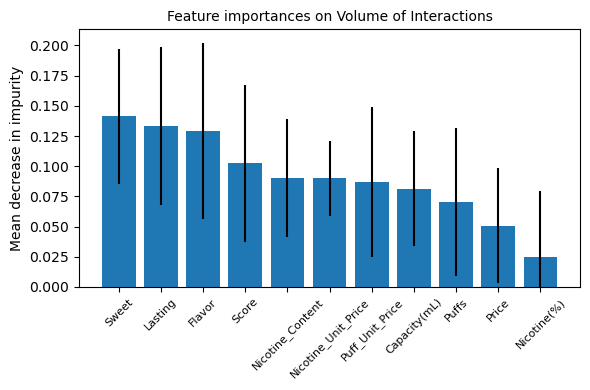

In [14]:
forest_importances = pd.DataFrame(importances, index = feature_names, columns = ['imp'])
forest_importances = forest_importances.reset_index().sort_values('imp', ascending=False)

fig, ax = plt.subplots(figsize = (6, 4))
plt.bar(forest_importances['index'], forest_importances.imp, yerr = std)
ax.tick_params(axis = 'x', labelrotation = 45, labelsize = 8)
ax.set_title("Feature importances on Volume of Interactions", fontsize = 10)
ax.set_ylabel("Mean decrease in impurity", fontsize = 10)
ax.set_ylim(bottom = 0)
fig.tight_layout()
plt.show()

Here we find that __the three major features of the product, sweetness, durability, and taste, have the highest importance value in the Feature importance algorithm of Random Forest__, and these features have a greater impact on the prediction results of the model.<p>
When a feature has a greater impact on the model's prediction results, it means that this feature is very important to the model's predictive ability. If this feature is removed or changed, the predictive ability of the model may be greatly affected. Conversely, if a feature has little predictive power to the model, then its importance is not that high, and its change or removal is unlikely to have a noticeable impact on the model's predictive power.<p>

### Review Clustering according to different scores

In this section, we will perform an unsupervised algorithmic classification on review text data.<p>
* First of all, we will divide the review text into three categories according to the star ratings given by consumers: perfect, favorable and negative (df_review_exc, df_review_mid, df_review_bad). Because we are curious about what the good and bad reviews are mainly saying.
* Subsequently, we encode the embeddings for reviews with different star ratings via a pre-trained short text encoding model for ___semantic extraction.___
* Using the output of the model as the input of the kmeans or agglomerative clustering classification algorithm, we can divide the comments into dozens of categories from a semantic point of view.
* Then we will read and try to understand what the focus or core point of each type of comment is. ___On this basis, we can more efficiently interpret the writers' intention and get user insight.___
* In addition, the cluster to which these reviews are assigned can also be used as a label to allow us to obtain more information about the product. For example, ___we can observe whether the reviews of a SKU with good sales are concentrated in a certain category, so as to understand why the product is more popular.___
* Here, due to the limited time of the project, only the code part of the semantic classification has been completed, and further reading comprehension has not been fully completed.
    
---

In [ ]:
# pip install -U sentence-transformers

In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [16]:
df_review.head(2)

,Best_Selling,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting,Review_id
0,1,5.0,11 hours,Less than 2 months,Awesome,I think you guys are awesome,5.0,5.0,5.0,1.0
1,1,5.0,12 hours,Less than 2 months,Lasts Long time,Great flavor and lasts a very long time,5.0,5.0,5.0,2.0


In [17]:
df_review_exc = df_review.loc[(df_review['Ratings'] == 5.0)]
df_review_mid = df_review.loc[(df_review['Ratings'] == 3.0)|(df_review['Ratings'] == 4.0)]
df_review_bad = df_review.loc[(df_review['Ratings'] == 1.0)|(df_review['Ratings'] == 2.0)]
df_review_bad.head(2)

,Best_Selling,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting,Review_id
36,1,1.0,13 days,Less than 2 months,Awesome,Exactly what I was expecting!!! Will order mor...,5.0,5.0,5.0,37.0
68,1,1.0,20 days,Less than 2 months,Strawberry ice cream,I like flum disposables but this flavor was no...,1.0,1.0,4.0,69.0


In [18]:
"""
Application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then k-mean clustering is applied.
"""
embedder = SentenceTransformer('all-MiniLM-L6-v2')
# embedder.model.max_seq_length = 256

reviews_bad = df_review_bad['Texts'].values
reviews_embeddings_bad = embedder.encode(reviews_bad)

print(np.shape(reviews_embeddings_bad))

(220, 384)


In [19]:
# # Perform kmean clustering
# start_time = time.time()

# num_clusters = 50
# clustering_model = KMeans(n_clusters = num_clusters)
# clustering_model.fit(reviews_embeddings)
# cluster_assignment = clustering_model.labels_

# elapsed_time = time.time() - start_time
# print(f"Elapsed time to perform the kmean clustering : {elapsed_time:.3f} seconds")

# clustered_sentences = [[] for i in range(num_clusters)]
# for sentence_id, cluster_id in enumerate(cluster_assignment):
#     clustered_sentences[cluster_id].append(reviews[sentence_id])

# # for i, cluster in enumerate(clustered_sentences):
# #     print("Cluster ", i+1)
# #     print(cluster)
# #     print("")

In [20]:
"""
Application for sentence embeddings: clustering
Sentences are mapped to sentence embeddings and then agglomerative clustering with a threshold is applied.
"""
# Normalize the embeddings to unit length
reviews_embeddings_bad = reviews_embeddings_bad/np.linalg.norm(reviews_embeddings_bad, axis=1, keepdims=True)

start_time = time.time()
clustering_model = AgglomerativeClustering(n_clusters = 50, distance_threshold = None) 
#, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(reviews_embeddings_bad)
cluster_assignment = clustering_model.labels_

elapsed_time = time.time() - start_time
print(f"Elapsed time to perform the kmean clustering : {elapsed_time:.3f} seconds")

clustered_sentences_bad = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences_bad:
        clustered_sentences_bad[cluster_id] = []

    clustered_sentences_bad[cluster_id].append(reviews_bad[sentence_id])

for i, cluster in clustered_sentences_bad.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Elapsed time to perform the kmean clustering : 0.025 seconds
Cluster  27
['Exactly what I was expecting!!! Will order more for sure!!!', 'Out of the 6 that I bought 2 of them was liking so it was trash', 'Not good was hoping it would be better won’t order this again']

Cluster  28
['I like flum disposables but this flavor was not it. It basically taste like it had actually dairy in it and like i was vaping rotten milk.', '"This brand doesn\'t last as long as the Steam Engine rechargeable do. Will not purchase the Flum brand again. Good taste on the Peach Ice Tea though"', 'Flum was one of my favorites disposable vape. Great selection of flavors. I never had problem with Flum before but this particular tropical punch is a no for me. Not sure if I got the defective one but i have to tilt the vape a certain way for the juice to flow. Also weird after taste.']

Cluster  43
['Nice', 'eh']

Cluster  42
['Taste a little different then what I am use to', "For me, this didn't taste like mixed b

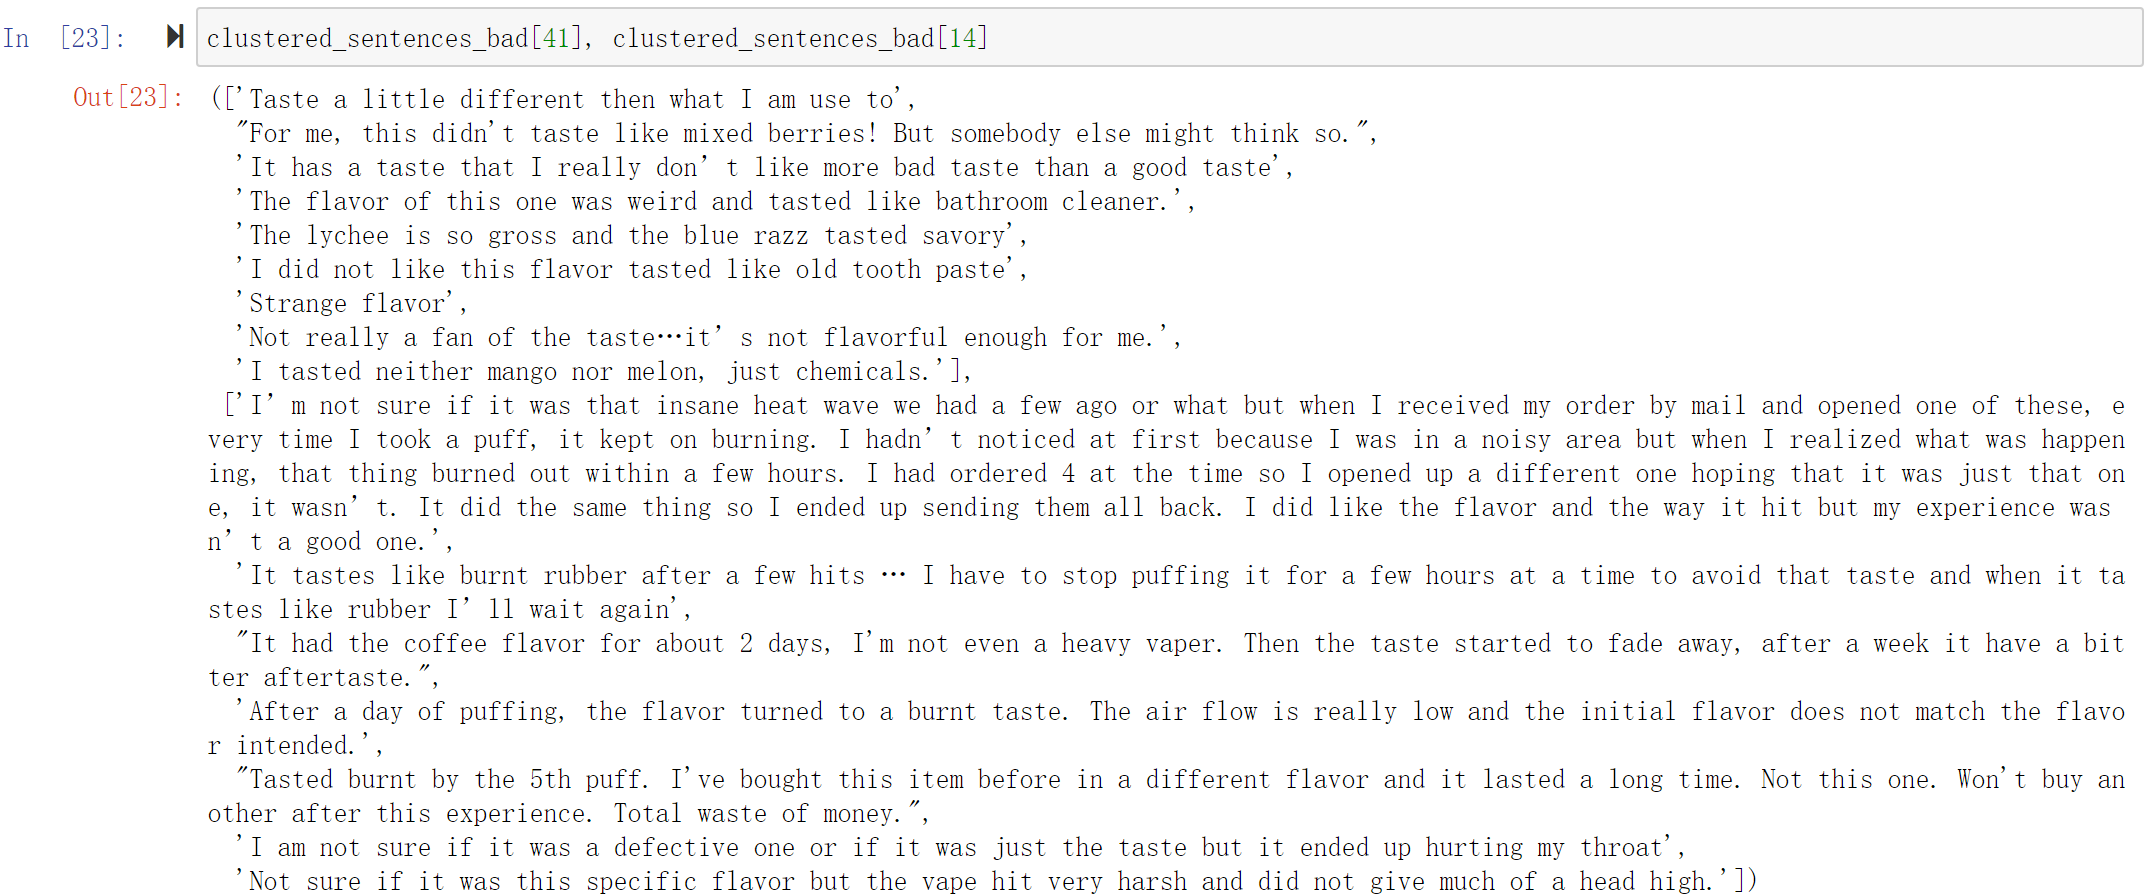

For example, in the clustering results of "terrible" review text, cluster14 represents the user's complaint that the product's battery is not rechargeable or drains too fast. <mark>___We found that a common problem with these products is that they cannot be recharged and the battery cannot be replaced, and sometimes the e-cigarette is out of power before the cartridge is exhausted, making it impossible to continue to use it.___<mark><p>
<mark>___Cluster41 represents users' dislike of vape flavors, and most of the reviews in this cluster emphasize the burnt taste of the product during use.___<mark>

###  Aspect Extraction and Word Cloud according to different scores

By using TextRank4Keyword algorithm and stylecloud python package, we could obtain :

---

In [21]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from stylecloud import gen_stylecloud
import stylecloud
from collections import OrderedDict

In [22]:
nlp = spacy.load('en_core_web_sm')

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Data cleaning : store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Build a vocab dictionary by getting all the tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        
        dict_keyword = {}
#         list_keywords = []
#         list_keyvalue = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            dict_keyword[key] = value
#             list_keywords.append(key)
#             list_keyvalue.append(value)
            print(key + ' - ' + str(value))
            if i > number:
                break
        return dict_keyword
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text)
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [23]:
feedbacks = ' '.join(df_review_exc['Texts'].astype(str).values)

key_extract = TextRank4Keyword()
key_extract.analyze(feedbacks, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=True)
dict_keyword_exc = key_extract.get_keywords(100)

flavor - 56.89511324362869
flavors - 26.944867701831022
vape - 24.843081931442292
taste - 20.5007815324311
time - 20.114772399633985
vapes - 16.200302875713643
product - 13.029940128459637
brand - 11.417355811453875
ice - 10.413734347447715
mint - 9.485720181318161
days - 8.903838043692632
love - 8.737730400800686
elf - 8.347379336358228
grape - 7.50908773659902
shipping - 7.434302465166097
bar - 7.143920540748094
price - 7.01535187971451
battery - 6.917664754725766
watermelon - 6.876916962825244
puffs - 6.824989194464256
strawberry - 6.77615239269842
day - 6.678179291454158
menthol - 6.59263407027468
flow - 6.469060668382466
service - 6.302777027436244
nicotine - 6.237193418410365
peach - 6.151522158142229
life - 6.144957938269796
puffers - 6.107440644533002
huff - 6.086897056430984
products - 6.082879919203107
flum - 6.022578690483726
favorites - 5.93746499258749
ones - 5.904981807778154
disposables - 5.890616624533377
air - 5.5602594268090035
quality - 5.442361417828153
mango - 5.43

In [24]:
feedbacks = ' '.join(df_review_bad['Texts'].values)

key_extract = TextRank4Keyword()
key_extract.analyze(feedbacks, candidate_pos = ['NOUN', 'PROPN'], window_size=4, lower=True)
dict_keyword_bad = key_extract.get_keywords(100)

flavor - 14.826809460158128
taste - 5.7131130571558755
ice - 4.415265531024723
vape - 3.7104306130580755
flavors - 3.0703189816769694
time - 2.5385638098615066
vapes - 2.5266185584325913
aloe - 2.1745113465077948
day - 2.163637062047329
hit - 2.113330900844745
strawberry - 1.983483739471398
size - 1.9471511835830597
brand - 1.9470689185626364
way - 1.9448808402223285
mango - 1.925762987205418
tastes - 1.8595282169669574
elf - 1.8265840530394044
icy - 1.7359002276069138
battery - 1.7259811690625027
mint - 1.7174429037082035
mouth - 1.6924945309507162
brands - 1.6888147899722643
hits - 1.670884906457471
days - 1.6646981107253556
cake - 1.5643440715566883
box - 1.5357240843084128
peach - 1.5070593130372707
product - 1.5046135898612225
berry - 1.498565167325542
cream - 1.4172544337345037
elfbar - 1.3901471559099288
juice - 1.389047610409747
watermelon - 1.3699988890642283
air - 1.3664843291153588
medicine - 1.3419857524922651
punch - 1.3047195179142475
bar - 1.275555989502628
issues - 1.27

In [25]:
stylecloud.gen_stylecloud(text = dict_keyword_exc,
                          size = 1024,
                          icon_name = 'fas fa-thumbs-up',
                          palette = 'colorbrewer.diverging.Spectral_11',
                          max_font_size = 1000,
                          max_words = 2000,
                          background_color = 'white',
                          gradient = 'vertical',
                          output_name = './review_exc.jpg',)

In [26]:
stylecloud.gen_stylecloud(text = dict_keyword_bad,
                          size = 1024,
                          icon_name = 'fas fa-thumbs-down',
                          colors = 'white',
                          background_color = 'black',
                          output_name = './review_bad.jpg',
                          collocations = False)

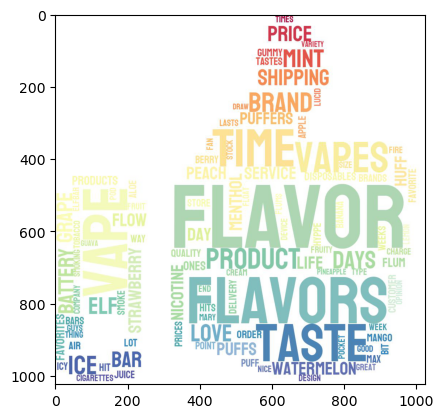

In [27]:
im = plt.imread('./review_exc.jpg')
plt.imshow(im)
plt.show()

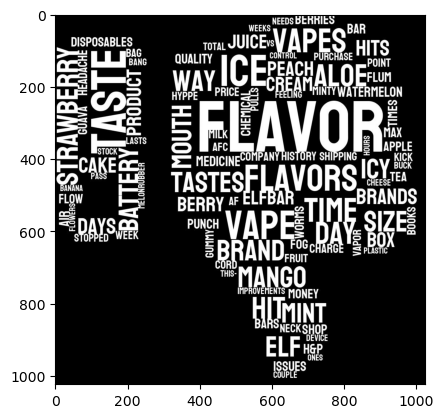

In [28]:
im = plt.imread('./review_bad.jpg')
plt.imshow(im)
plt.show()

We found that there is not much difference in the key aspect term extraction results for positive and negative reviews, mainly in:

In [29]:
aspect_list = ['flavor', 'taste', 'vape', 'time', 'flum', 'battery', 
               'mint', 'strawberry', 'aloe', 'ice', 'grape', 'menthol', 'mango', 'lychee', 'fruity',
               'delivery', 'shipping', 'service']

### Sentiment Analysis of Aspect Terms for one given product

Based on the above key term extraction results, we will next ___study what the potential emotional expressions of these words are in different products, so that we can know which products perform better or need to be improved on which features.___<p>
In order to achieve this function, we need to train a separate sentiment analysis neural network on the text review data under each product. Below we take df_review_1 with the largest number of reviews as an example. Due to time constraints, we have not completed the sentiment comparison of feature words between different products for the time being.

---

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM

In [31]:
df_review_1['Recommendation'] = df_review_1['Ratings'].apply(lambda x: 1 if x >= 4 else 0)
df_review_1.head()

,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting,Recommendation
Review_id,,,,,,,,,
1,5.0,11 hours,Less than 2 months,Awesome,I think you guys are awesome,5.0,5.0,5.0,1
2,5.0,12 hours,Less than 2 months,Lasts Long time,Great flavor and lasts a very long time,5.0,5.0,5.0,1
3,5.0,18 hours,Less than 2 months,I like these vapes,Last a while too,3.0,3.0,3.0,1
4,5.0,20 hours,Less than 2 months,Love this one.,Flavor was great and lasted a while.,5.0,5.0,5.0,1
5,5.0,3 days,Less than 2 months,Flum Pina Polo,This is great! Has the pineapple taste and no ...,5.0,5.0,5.0,1


In [32]:
tokenizer = Tokenizer(oov_token = "<OOV>") # num_words = vocab_size, 
tokenizer.fit_on_texts(df_review_1['Texts'])
word_index = tokenizer.word_index

print('word index for bad is', word_index['bad'])
print('word_index length is', len(word_index))

word index for bad is 271
word_index length is 1401


In [33]:
max_length = 256
padding_type = 'post'
trunc_type = 'post'

sequences = tokenizer.texts_to_sequences(df_review_1['Texts'].values)
review_padded = pad_sequences( sequences, 
                               padding = padding_type, 
                               truncating = trunc_type, 
                               maxlen = max_length)

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(sequence):
    return ' '.join([reverse_word_index.get(index, '?') for index in sequence])

print(decode_review(sequences[10]))
print(df_review_1['Texts'].values[10])

i love this flavor but the orange is my faaaavorite and love how it slides in and out of my mouf
I love this flavor . but the ORANGE is my faaaavorite and love how it slides in and out of my mouf !


In [35]:
review_recomm = tf.convert_to_tensor(df_review_1['Recommendation'].values)
review_padded = tf.convert_to_tensor(review_padded)

train_sample_num = 950
test_sample_num  = 83

x_train, x_test = tf.split(review_padded, 
                           num_or_size_splits=[train_sample_num, test_sample_num], axis=0)

y_train, y_test = tf.split(review_recomm, 
                           num_or_size_splits=[train_sample_num, test_sample_num], axis=0)

x_train = x_train.numpy()
x_test = x_test.numpy()
y_train = y_train.numpy()
y_test = y_test.numpy()
print("Training entries: {}, labels: {}".format(len(x_train), len(y_train)))

Training entries: 950, labels: 950


In [36]:
vocab_size = 2000

# model = keras.Sequential([
#     keras.layers.Embedding(vocab_size, 384), 
#     Bidirectional(LSTM(32, 
#                 dropout=0.5, 
#                 recurrent_dropout=0.5)),
#     Dense(16, activation='relu', kernel_regularizer='l2'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')])

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 384))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 384)         768000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               98560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                4112      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 870,689
Trainable params: 870,689
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
history = model.fit(x_train,
                    y_train,
                    epochs = 40,
                    batch_size = 128)

Epoch 1/40
8/8 [==============================] - ETA: 7s - loss: 0.7154 - accuracy: 0.10 - ETA: 0s - loss: 0.7073 - accuracy: 0.18 - ETA: 0s - loss: 0.7049 - accuracy: 0.26 - ETA: 0s - loss: 0.7030 - accuracy: 0.32 - ETA: 0s - loss: 0.7013 - accuracy: 0.38 - ETA: 0s - loss: 0.6999 - accuracy: 0.42 - 1s 52ms/step - loss: 0.6979 - accuracy: 0.4929
Epoch 2/40
8/8 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.94 - ETA: 0s - loss: 0.6747 - accuracy: 0.94 - ETA: 0s - loss: 0.6731 - accuracy: 0.94 - ETA: 0s - loss: 0.6723 - accuracy: 0.94 - ETA: 0s - loss: 0.6714 - accuracy: 0.94 - ETA: 0s - loss: 0.6706 - accuracy: 0.94 - 0s 59ms/step - loss: 0.6694 - accuracy: 0.9464
Epoch 3/40
8/8 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.97 - ETA: 0s - loss: 0.6448 - accuracy: 0.96 - ETA: 0s - loss: 0.6441 - accuracy: 0.96 - ETA: 0s - loss: 0.6431 - accuracy: 0.96 - ETA: 0s - loss: 0.6423 - accuracy: 0.96 - ETA: 0s - loss: 0.6415 - accuracy: 0.95 - 

In [39]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

3/3 - 0s - loss: 0.1248 - accuracy: 0.9759
[0.12483296543359756, 0.9759036302566528]


In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy'])

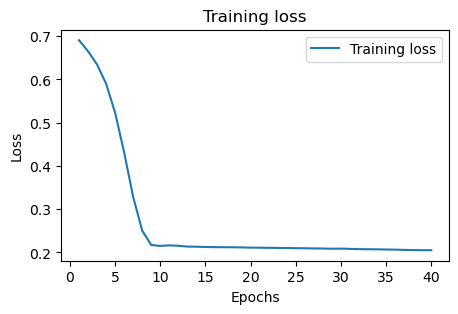

In [41]:
acc = history_dict['accuracy']
loss = history_dict['loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize = (5, 3))
plt.plot(epochs, loss, label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

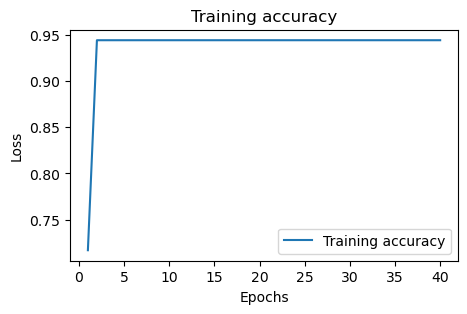

In [42]:
plt.figure(figsize = (5, 3))
plt.plot(epochs, acc, label='Training accuracy')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
print(decode_review(sequences[190]))
print('Sentiment prediction of positive level is', model.predict([x_train[190]])[0][0])

helped my to stop smoking cigarettes
Sentiment prediction of positive level is 0.8469111


In [44]:
aspect_list = ['flavor', 'taste', 'vape', 'time', 'flum', 'battery', 
               'mint', 'strawberry', 'aloe', 'ice', 'grape', 'menthol', 'mango', 'lychee', 'fruity',
               'delivery', 'shipping', 'service']

for str_test in aspect_list:
    sequences_test = tokenizer.texts_to_sequences([str_test])
    review_padded_test = pad_sequences(sequences_test, 
                                       padding = padding_type, 
                                       truncating = trunc_type, 
                                       maxlen = max_length)

    print('Positive level prediction for {} is'.format(str_test), model.predict([review_padded_test])[0][0])

Positive level prediction for flavor is 0.9458471
Positive level prediction for taste is 0.94519585
Positive level prediction for vape is 0.94753385
Positive level prediction for time is 0.9466909
Positive level prediction for flum is 0.9471861
Positive level prediction for battery is 0.9459896
Positive level prediction for mint is 0.94614077
Positive level prediction for strawberry is 0.94682014
Positive level prediction for aloe is 0.94629174
Positive level prediction for ice is 0.94557095
Positive level prediction for grape is 0.9466872
Positive level prediction for menthol is 0.94719344
Positive level prediction for mango is 0.945609
Positive level prediction for lychee is 0.9467565
Positive level prediction for fruity is 0.946329
Positive level prediction for delivery is 0.9461657
Positive level prediction for shipping is 0.9475644
Positive level prediction for service is 0.9473784


In the review text of the product with the highest sales volume, keywords related to product attributes, such as: 'flavor', 'taste', time', 'flum', 'battery', all have good positive sentiment scores . At the same time, words related to products and services, like 'delivery', 'shipping', 'service', also perform well. And for different flavors of the product, such as 'mint', 'strawberry', 'aloe', 'ice', 'grape', 'menthol', 'mango', 'lychee', 'fruity', we can even sort which flavors are more popular with consumers.

### Trend over time in the volume of interactions

When doing comment data scraping, we noticed that the upper right corner of each comment also saves the time when the comment was published, which can give us information about product popularity or product sales over time. By studying time series of this and other information, we can try to <mark>predict the sales performance of different products over time in the future.<mark> In addition, we can predict the more popular keywords in the future by analyzing the time trend of the scores obtained by different product features, and provide ideas for the company's marketing and product strategies.

---

In [45]:
df_review_1.head()

,Ratings,Dates,Date_Category,Heads,Texts,Flavor,Sweet,Lasting,Recommendation
Review_id,,,,,,,,,
1,5.0,11 hours,Less than 2 months,Awesome,I think you guys are awesome,5.0,5.0,5.0,1
2,5.0,12 hours,Less than 2 months,Lasts Long time,Great flavor and lasts a very long time,5.0,5.0,5.0,1
3,5.0,18 hours,Less than 2 months,I like these vapes,Last a while too,3.0,3.0,3.0,1
4,5.0,20 hours,Less than 2 months,Love this one.,Flavor was great and lasted a while.,5.0,5.0,5.0,1
5,5.0,3 days,Less than 2 months,Flum Pina Polo,This is great! Has the pineapple taste and no ...,5.0,5.0,5.0,1


In [46]:
df_review_1['Dates'].unique()

array(['11 hours', '12 hours', '18 hours', '20 hours', '3 days', '4 days',
       '5 days', '6 days', '7 days', '8 days', '9 days', '10 days',
       '11 days', '12 days', '13 days', '14 days', '15 days', '16 days',
       '18 days', '19 days', '20 days', '21 days', '22 days', '23 days',
       '24 days', '25 days', '26 days', '27 days', '28 days', '29 days',
       '30 days', '1 month', '2 months', '3 months', '4 months',
       '5 months', '6 months', '7 months', '8 months', '9 months',
       '10 months', '11 months', '12 months', '1 year', '2 years'],
      dtype=object)

In [47]:
def date_cat_1(x):
    if x.split()[1] == 'years':
        cat = '2 years ago'
    elif x.split()[1] == 'year':
        cat = '1 to 2 years ago'
    elif x.split()[1][0:5] == 'month':
        cat = '{} months ago'.format(int(x.split()[0]))
    else:
        cat = 'Less than 1 month'
    return cat

def ReviewTrend(df_review_product):
    """
    Function who returns two graphs, showing how the number of reviews received by this product has changed over time, 
    with the upper graph showing the change over the past year,
    and the lower graph showing the approximate change over the past three years.
    """
    df_review_no = df_review_product.copy()
    df_review_no['Date_Category'] = df_review_no['Dates'].apply(lambda x : date_cat_1(x))

    order = []
    for elem in df_review_no['Date_Category']:
        if elem not in order:
            order.append(elem)

    df_review_no['category'] = pd.Categorical(df_review_no['Date_Category'], categories=order)

    df_counts_no = df_review_no.groupby('category').size().reset_index(name='count')
    df_counts_no = df_counts_no.sort_values('category')

    new_row = pd.DataFrame({'category': 'In 1 year', 'count': df_counts_no.iloc[0:13]['count'].sum()}, index = [0])
    df_counts_no = pd.concat([df_counts_no.iloc[:12+1], new_row, df_counts_no.iloc[12+1:]]).reset_index(drop = True)

    plt.figure(figsize = (5, 8))
    plt.subplot(211)
    plt.barh(df_counts_no['category'].loc[0:12], df_counts_no['count'].loc[0:12])
    plt.title('Trend of Volume of interactions within 1 year')
    plt.ylabel('Time')
    plt.xlabel('Count of reviews')

    plt.subplot(212)
    plt.bar(df_counts_no['category'].loc[13:15], df_counts_no['count'].loc[13:15])
    plt.title('Trend of Volume of interactions in 3 years')
    plt.xlabel('Time')
    plt.ylabel('Count of reviews')

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.4, wspace=0.4)
    plt.show()

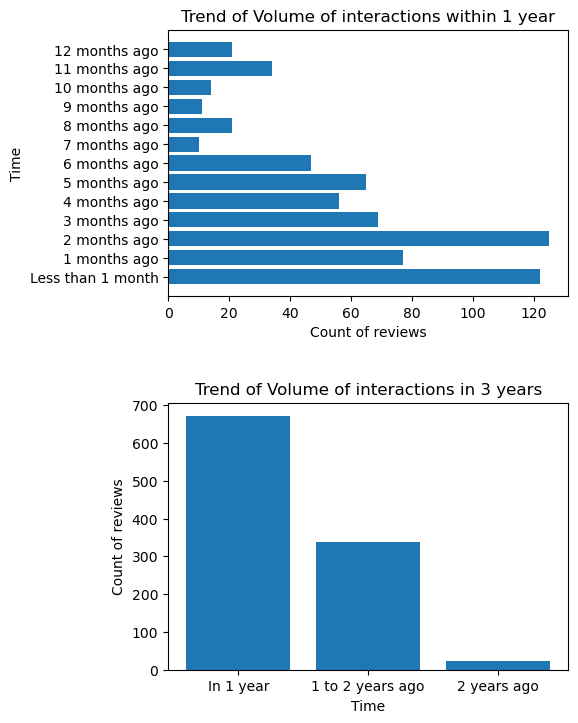

In [48]:
ReviewTrend(df_review_1)

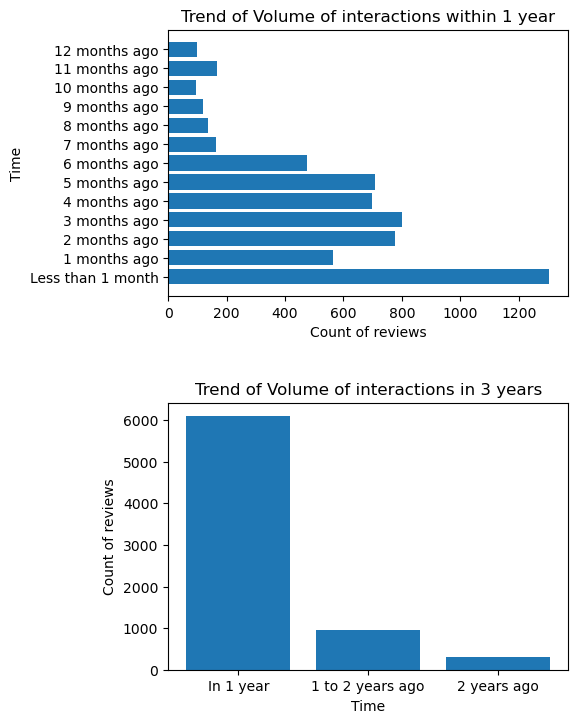

In [49]:
ReviewTrend(df_review)

We found that the total number of comments received on the website, that is, the total number of user interactions, ___has grown rapidly during this year, especially in the past six months___. ___In the past three years, the total number of reviews has grown significantly__. This means that __the industry has more and more consumers, <mark>and the market for vape products is expanding rapidly___<mark>. However, perhaps this is also related to the recovery of the market after the covid epidemic. <mark>The ___market performance is getting better and better with the relaxation of the covid prevention and control policy and the recovery of the supply chain.___<mark>